# Electro-elastic "creasing" instability

- Code for 3D large deformation electro-elasticity with u-p formulation

- Electro-viscoelastic instability of electrocreasing.
- Uses quadrature representation of internal variable: viscous deformation tensor Cv.
- VHB material properties taken from Wang et al., JMPS (2016).

### Units
- Length: mm
- Mass: kg  
- Time:  s
- Charge: nC
- Force: mN
- Stress: kPa 
- Energy: microJ
- Electric potential: kV

### Software:
- Dolfinx v0.8.0

# Import modules

In [48]:
# Import FEnicSx/dolfinx
import dolfinx

# For numerical arrays
import numpy as np

# For MPI-based parallelization
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

# PETSc solvers
from petsc4py import PETSc

# specific functions from dolfinx modules
from dolfinx import fem, mesh, io, plot, log
from dolfinx.fem import (Constant, dirichletbc, Function, functionspace, Expression )
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
from dolfinx.io import VTXWriter, XDMFFile


# specific functions from ufl modules
import ufl
from ufl import (TestFunctions, TrialFunction, Identity, grad, det, div, dev, inv, tr, sqrt, conditional ,\
                 gt, dx, inner, derivative, dot, ln, split, exp, eq, cos, acos, ge, le, outer)

# basix finite elements
import basix
from basix.ufl import element, mixed_element, quadrature_element

# Matplotlib for plotting
import matplotlib.pyplot as plt
plt.close('all')

# For timing the code
from datetime import datetime


# Set level of detail for log messages (integer)
# Guide:
# CRITICAL  = 50, // errors that may lead to data corruption
# ERROR     = 40, // things that HAVE gone wrong
# WARNING   = 30, // things that MAY go wrong later
# INFO      = 20, // information of general interest (includes solver info)
# PROGRESS  = 16, // what's happening (broadly)
# TRACE     = 13, // what's happening (in detail)
# DBG       = 10  // sundry
#
log.set_log_level(log.LogLevel.WARNING)

# Define geometry

In [49]:
# plane strain rectangle nominal dimensions
width = 20.0 #mm
height = 120.0 #mm

In [50]:


# Read in the 2D mesh and cell tags
with XDMFFile(MPI.COMM_WORLD,"meshes/ElectroCrease_v2.xdmf",'r') as infile:
    domain = infile.read_mesh(name="Grid",xpath="/Xdmf/Domain")
    cell_tags = infile.read_meshtags(domain,name="Grid")
domain.topology.create_connectivity(domain.topology.dim, domain.topology.dim-1)

# Also read in 1D facets for applying BCs
with XDMFFile(MPI.COMM_WORLD,"meshes/line_ElectroCrease_v2.xdmf",'r') as infile:
    facet_tags = infile.read_meshtags(domain,name="Grid")

x = ufl.SpatialCoordinate(domain)

**Print out the unique cell index numbers**

In [51]:
top_imap = domain.topology.index_map(2)      # index map of 2D entities in domain
values = np.zeros(top_imap.size_global)      # an array of zeros of the same size as number of 2D entities
values[cell_tags.indices]=cell_tags.values   # populating the array with facet tag index numbers
print(np.unique(cell_tags.values))           # printing the unique indice

[11]


In [52]:
# Identify the planar boundaries of the mesh
#
def Left(x):
    return np.isclose(x[0], 0.0)
def Right(x):
    return np.isclose(x[0], width)
def Top(x):
    return np.isclose(x[1], 120.0)
def Bottom(x):
    return np.isclose(x[1], 0.0)
def LeftTop(x):
    return np.logical_and(np.isclose(x[1] - (0.12/0.02)*x[0], 119.88), x[0]<0.02)

# Mark the sub-domains
boundaries = [(1,Left),(2,Right),(3,Top),(4,Bottom),(5,LeftTop)]


# build collections of facets on each subdomain and mark them appropriately.
facet_indices, facet_markers = [], [] # initalize empty collections of indices and markers.
fdim = domain.topology.dim - 1 # geometric dimension of the facet (mesh dimension - 1)
for (marker, locator) in boundaries:
    facets = mesh.locate_entities(domain, fdim, locator) # an array of all the facets in a 
                                                         # given subdomain ("locator")
    facet_indices.append(facets)                         # add these facets to the collection.
    facet_markers.append(np.full_like(facets, marker))   # mark them with the appropriate index.

# Format the facet indices and markers as required for use in dolfinx.
facet_indices = np.hstack(facet_indices).astype(np.int32)
facet_markers = np.hstack(facet_markers).astype(np.int32)
sorted_facets = np.argsort(facet_indices)
# 
# Add these marked facets as "mesh tags" for later use in BCs.
facet_tags = mesh.meshtags(domain, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])

**Print out the unique facet index numbers**

In [53]:
# top_imap = domain.topology.index_map(2)      # index map of 2D entities in domain (facets)
# values = np.zeros(top_imap.size_global)      # an array of zeros of the same size as number of 2D entities
# values[facet_tags.indices]=facet_tags.values # populating the array with facet tag index numbers
print(np.unique(facet_tags.values))          # printing the unique indices

[1 2 3 4 5]


**Visualize reference configuration and boundary facets**

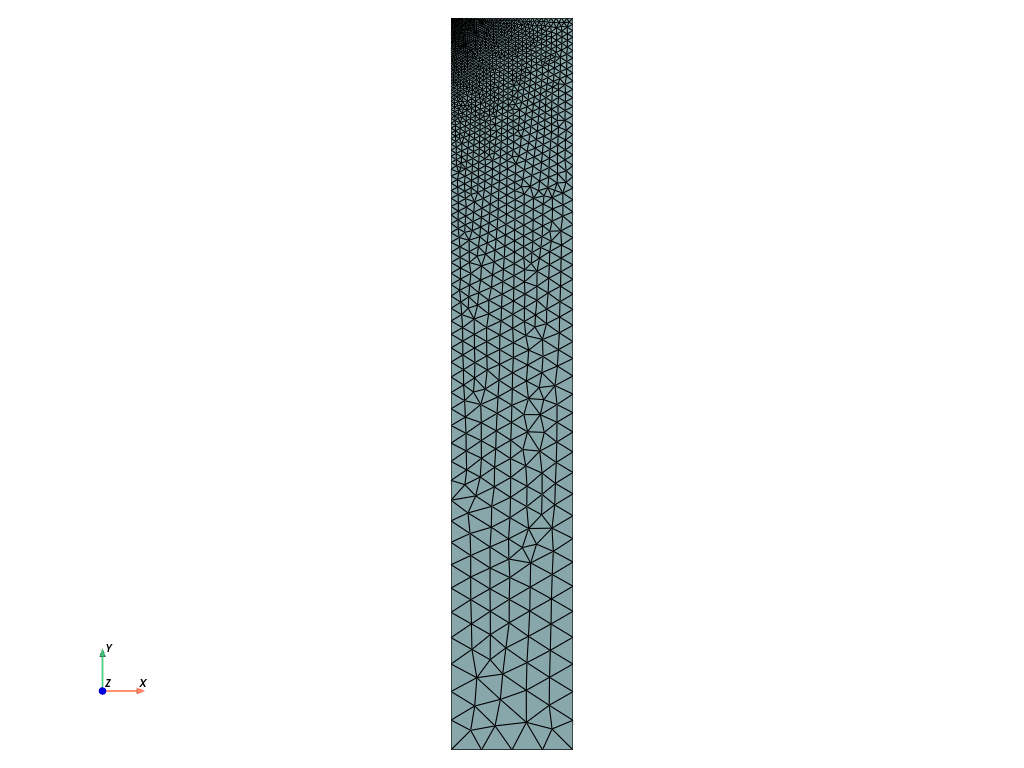

In [54]:
import pyvista
pyvista.set_jupyter_backend('html')
from dolfinx.plot import vtk_mesh
pyvista.start_xvfb()

# initialize a plotter
plotter = pyvista.Plotter()

# Add the mesh.
topology, cell_types, geometry = plot.vtk_mesh(domain, domain.topology.dim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
plotter.add_mesh(grid, show_edges=True) 
# plotter.add_mesh(grid, show_edges=False) 

# # Add colored surfaces
# color_surf = pyvista.UnstructuredGrid(*vtk_mesh(domain, domain.topology.dim-1,facet_tags.indices[facet_tags.values==5]) )
# actor = plotter.add_mesh(color_surf, show_edges=True,color="red")

labels = dict(zlabel='Z', xlabel='X', ylabel='Y')
plotter.add_axes(**labels)
plotter.view_xy()

plotter.screenshot("results/ElectroCreaseMesh.png")

from IPython.display import Image
Image(filename='results/ElectroCreaseMesh.png') 

### Un-comment this cell to see an interactive visualization of the mesh

In [55]:
# plotter.show()

## Define boundary and volume integration measure

In [56]:
# Define the boundary integration measure "ds" using the facet tags,
# also specify the number of surface quadrature points.
ds = ufl.Measure('ds', domain=domain, subdomain_data=facet_tags, metadata={'quadrature_degree':4})

# Define the volume integration measure "dx" 
# also specify the number of volume quadrature points.
dx = ufl.Measure('dx', domain=domain, metadata={'quadrature_degree': 4})

# Create facet to cell connectivity required to determine boundary facets.
domain.topology.create_connectivity(domain.topology.dim, domain.topology.dim)
domain.topology.create_connectivity(domain.topology.dim, domain.topology.dim-1)
domain.topology.create_connectivity(domain.topology.dim-1, domain.topology.dim)

#  Define facet normal
n2D = ufl.FacetNormal(domain)
n = ufl.as_vector([ufl.FacetNormal(domain)[0], ufl.FacetNormal(domain)[1], 0.0])

# Material parameters

In [57]:
# Equilibrium material parameters
#
rho = Constant(domain, PETSc.ScalarType(1e-6))           # 1000 kg/m^3 = 1e-6 kg/mm^3
#
Geq_0   = Constant(domain, PETSc.ScalarType(15.36))      # Shear modulus, kPa
Kbulk   = Constant(domain, PETSc.ScalarType(1e3*Geq_0))  # Bulk modulus, kPa
lambdaL = Constant(domain, PETSc.ScalarType(5.99))        # Arruda-Boyce locking stretch

# Viscoelasticity parameters from Wang et al (2016) for VHB4910
#
Gneq_1  = Constant(domain, PETSc.ScalarType(26.06))    #  Non-equilibrium shear modulus, kPa
tau_1   = Constant(domain, PETSc.ScalarType(0.6074))   #  relaxation time, s
#
Gneq_2  = Constant(domain, PETSc.ScalarType(26.53))    #  Non-equilibrium shear modulus, kPa
tau_2   = Constant(domain, PETSc.ScalarType(6.56))     #  relaxation time, s
#
Gneq_3  = Constant(domain, PETSc.ScalarType(10.83))    #  Non-equilinrium shear modulus, kPa
tau_3   = Constant(domain, PETSc.ScalarType(61.25))    #  relaxation time, s

# Electrostatic  parameters
vareps_0 = Constant(domain, PETSc.ScalarType(8.85E-3)) #  permittivity of free space pF/mm
vareps_r = Constant(domain, PETSc.ScalarType(4.8))     #  relative permittivity, dimensionless
vareps   = vareps_r*vareps_0         #  permittivity of the material

# Simulation time-control related params

In [58]:
# start time (sec)
t = 0.0

# ramp rate (1/sec)
rampRate = 1.0e-3

# Final value of phi.  Normalization parameter for voltage: l*sqrt(Geq_0/vareps)
#
phiNorm = 1.25
phiTot = phiNorm*float(height*np.sqrt(float(Geq_0)/float(vareps)))

# Time for loading / unloading (sec)
#
StepTime = phiNorm/rampRate

# total simulation time (sec)
#
Ttot = StepTime*2.0

# initial time step size (sec)
#
dt = StepTime/100

# Create a constant for the time step
#
dk = Constant(domain, PETSc.ScalarType(dt))

# Function to ramp the applied potential
def phiRamp(t):
    if(t<=StepTime):
        phi = phiTot*t/StepTime
    else:
        # phi = phiTot - (phiTot/StepTime)*(t-StepTime) # this is laod-unload
        phi = phiTot # this is a ramp and hold
    return phi

# Generalized-alpha method parameters for calculating acceleration and velocity
alpha   = Constant(domain, PETSc.ScalarType(0.0))
gamma   = Constant(domain, PETSc.ScalarType(0.5+alpha))
beta    = Constant(domain, PETSc.ScalarType(0.25*(gamma+0.5)**2))

# Function spaces

In [59]:

U2 = element("Lagrange", domain.basix_cell(), 1, shape=(2,))  # For displacement
P1 = element("Lagrange", domain.basix_cell(), 1)  # For pressure and electric potential
P0 = quadrature_element(domain.basix_cell(), degree=2, scheme="default")
# Note: it seems that for the current version of dolfinx, 
# only degree=2 quadrature elements actually function properly 
# in e.g. visualization interpolations and problem solution.
T0 = basix.ufl.blocked_element(P0, shape=(3, 3)) # for Cv
#
TH = mixed_element([U2, P1, P1])  # Taylor-Hood style mixed element
ME = functionspace(domain, TH)    # Total space for all DOFs
#
V1 = functionspace(domain, P1) # Scalar function space.
V2 = functionspace(domain, U2) # Vector function space
V3 = functionspace(domain, T0) # Tensor function space
#
# Define actual functions with the required DOFs
w = Function(ME)
u, p, phi = split(w) # displacement u, presssure p, and electric potential phi

# A copy of functions to store values in the previous step
w_old  = Function(ME)
u_old, p_old, phi_old = split(w_old)   

# Define test functions   
u_test, p_test, phi_test = TestFunctions(ME)    

# Define trial functions needed for automatic differentiation
dw = TrialFunction(ME)

# Define a tensor-valued function for Cv.
Cv_1_old = Function(V3) 
Cv_2_old = Function(V3) 
Cv_3_old = Function(V3) 

# Functions for storing the velocity and acceleration at prev. step
v_old = Function(V2)
a_old = Function(V2)

# Initial conditions: 

# A function for constructing the identity matrix.
#
# To use the interpolate() feature, this must be defined as a 
# function of x.
def identity(x):
    values = np.zeros(((domain.geometry.dim+1)*(domain.geometry.dim+1),
                      x.shape[1]), dtype=np.float64)
    values[0] = 1
    values[4] = 1
    values[8] = 1
    return values

# interpolate the identity onto the tensor-valued Cv function.
Cv_1_old.interpolate(identity)  
Cv_2_old.interpolate(identity) 
Cv_3_old.interpolate(identity)   

# Subroutines for kinematics and constitutive equations

In [60]:
#------------------------------------------------------------- 
# Utility subroutines
#-------------------------------------------------------------

# Macaulay bracket function
def ppos(x):
    return (x+abs(x))/2.

# Opposite of Macaulay brackets, take only when negative
def pneg(x):
    return (abs(x)-x)/2.

# Subroutine for a "safer" sqrt() function which avoids a divide by zero 
# when differentiated. 
def safe_sqrt(x):
    return sqrt(x + 1.0e-16)

# Special gradient operators for plane strain 
#
# Gradient of vector field u   
def pe_grad_vector(u):
    grad_u = grad(u)
    pe_grad_u = ufl.as_tensor([ [grad_u[0,0], grad_u[0,1], 0.0],
                                [grad_u[1,0], grad_u[1,1], 0.0],
                                [        0.0,         0.0, 0.0] ]) 
    return pe_grad_u

# Gradient of scalar field y
# (just need an extra zero for dimensions to work out)
def pe_grad_scalar(y):
    grad_y = grad(y)
    pe_grad_y = ufl.as_vector([grad_y[0], grad_y[1], 0.0])
    return pe_grad_y


#------------------------------------------------------------- 
# Subroutines for kinematics
#-------------------------------------------------------------

# Plane strain deformation gradient 
def F_calc(u):
    dim = len(u)                # dimension of problem (2)
    Id = Identity(dim)          # 2D Identity tensor
    F = Id + grad(u)            # 2D Deformation gradient
    F_pe =  ufl.as_tensor([ [F[0,0], F[0,1], 0.0],
                            [F[1,0], F[1,1], 0.0],
                            [   0.0,    0.0, 1.0] ]) # Full plane strain F
    return F_pe

# Subrountine for computing the effective stretch
def lambdaBar_calc(u):
    F = F_calc(u)
    J = det(F)
    Fbar = J**(-1/3)*F
    Cbar = Fbar.T*Fbar
    I1 = tr(Cbar)
    lambdaBar = safe_sqrt(I1/3.0)
    return lambdaBar

#------------------------------------------------------------- 
# Subroutines for computing the viscous flow update
#-------------------------------------------------------------

# Subroutine for computing the viscous stretch Cv at the end of the step.
def Cv_update(u, Cv_old, tau_r):
    F = F_calc(u)
    J = det(F)
    C = F.T*F
    # new update from Shawn here
    Cbar = J**(-2./3.)*C
    fac = Cv_old + (dk/tau_r)*Cbar
    Cv_new = (det(fac))**(-1./3.) * fac
    return Cv_new 
 
#------------------------------------------------------------- 
# Subroutines for calculating the electric field and displacement
#-------------------------------------------------------------

# Referential electric displacement 
def Dmat_calc(u, phi):
    F = F_calc(u)
    J = det(F)
    C = F.T*F
    e_R  = - pe_grad_scalar(phi) # referential electric field
    Dmat = vareps * J* inv(C)*e_R
    return Dmat

#------------------------------------------------------------- 
# Subroutines for calculating the Cauchy stress
#-------------------------------------------------------------

# Subroutine for computing the zeta-function in the Arruda-Boyce model.
def zeta_calc(u):
    lambdaBar = lambdaBar_calc(u)
    # Use Pade approximation of Langevin inverse (A. Cohen, 1991)
    # This is sixth-order accurate.
    z = lambdaBar/lambdaL
    z = conditional(gt(z,0.99), 0.99, z) # Keep from blowing up
    beta = z*(3.0 - z**2.0)/(1.0 - z**2.0)
    zeta = (lambdaL/(3*lambdaBar))*beta
    return zeta

# Generalized shear modulus for Arruda-Boyce model
def Geq_AB_calc(u):
    zeta = zeta_calc(u)
    Geq_AB  = Geq_0 * zeta
    return Geq_AB

# Subroutine for calculating the  equilibrium Cauchy stress
def T_eq_calc(u,p):
    F = F_calc(u)
    J = det(F)
    Fbar = J**(-1./3.)*F
    Bbar = Fbar*Fbar.T
    Geq  = Geq_AB_calc(u)
    T_eq = (1/J)* Geq * dev(Bbar) - p * Identity(3)
    return T_eq


# Subroutine for calculating the electrotatic contribution to the Cauchy stress
def T_maxw_calc(u,phi):
    F = F_calc(u)
    e_R  = - pe_grad_scalar(phi)    # referential electric field
    e_sp = inv(F.T)*e_R   # spatial electric field 
    # Spatial Maxwel stress
    T_maxw = vareps*(outer(e_sp,e_sp) - 1/2*(inner(e_sp,e_sp))*Identity(3))
    return T_maxw

# Subroutine for the non-equilibrium Cauchy stress.
def T_neq_calc(u, Cv, Gneq):
    F  = F_calc(u)
    J = det(F)
    C = F.T*F
    # Shawn update here
    Fbar = J**(-1./3.) * F
    Cbar = J**(-2./3.) * C
    T_neq = J**(-1.) * Gneq * (Fbar * inv(Cv) * Fbar.T - (1./3.) * inner(Cbar, inv(Cv)) * Identity(3) ) 
    return T_neq

#------------------------------------------------------------- 
# Subroutine for calculating the total Piola stress
#-------------------------------------------------------------
   
# Subroutine for the total Piola stress.
def  Piola_calc(u, p, Cv_1, Cv_2, Cv_3, Gneq_1, Gneq_2, Gneq_3):
    F  = F_calc(u)
    J = det(F)
    
    T_eq = T_eq_calc(u,p)
    
    T_maxw = T_maxw_calc(u,phi)
    
    T_neq_1 = T_neq_calc(u, Cv_1, Gneq_1)
    
    T_neq_2 = T_neq_calc(u, Cv_2, Gneq_2)
        
    T_neq_3 = T_neq_calc(u, Cv_3, Gneq_3)
    
    T = T_eq + T_maxw + T_neq_1 + T_neq_2 + T_neq_3
    
    Piola = J*T*inv(F.T)
    
    return Piola

#---------------------------------------------------------------------
# Subroutine for updating  acceleration using the Newmark beta method:
# a = 1/(2*beta)*((u - u0 - v0*dt)/(0.5*dt*dt) - (1-2*beta)*a0)
#---------------------------------------------------------------------
def update_a(u, u_old, v_old, a_old):
    return (u-u_old-dk*v_old)/beta/dk**2 - (1-2*beta)/2/beta*a_old

#---------------------------------------------------------------------
# Subroutine for updating  velocity using the Newmark beta method
# v = dt * ((1-gamma)*a0 + gamma*a) + v0
#---------------------------------------------------------------------
def update_v(a, u_old, v_old, a_old):
    return v_old + dk*((1-gamma)*a_old + gamma*a)

#---------------------------------------------------------------------
# alpha-method averaging function
#---------------------------------------------------------------------
def avg(x_old, x_new, alpha):
    return alpha*x_old + (1-alpha)*x_new

# Evaluate kinematics and constitutive relations

In [61]:
# Get acceleration and velocity at end of step
a_new = update_a(u, u_old, v_old, a_old)
v_new = update_v(a_new, u_old, v_old, a_old)

# get avg (u,p) fields for generalized-alpha method
u_avg  = avg(u_old, u, alpha)
p_avg  = avg(p_old, p, alpha)

# Kinematical quantities
F  = F_calc(u_avg)
J  = det(F)
lambdaBar = lambdaBar_calc(u_avg)

# update the Cv tensors
Cv_1 = Cv_update(u_avg, Cv_1_old, tau_1)
Cv_2 = Cv_update(u_avg, Cv_2_old, tau_2)
Cv_3 = Cv_update(u_avg, Cv_3_old, tau_3)

# Referential electric displacement
Dmat = Dmat_calc(u_avg, phi)

#  Evaulate the total Piola stress
Piola = Piola_calc(u_avg, p_avg, Cv_1, Cv_2, Cv_3, Gneq_1, Gneq_2, Gneq_3)

# Weak forms

In [62]:
# The weak form for the equilibrium equation
#
Res_1  =  inner( Piola, pe_grad_vector(u_test))*dx \
   + inner(rho*a_new, u_test)*dx

# The auxiliary equation for the pressure
#
Res_2 = inner((p_avg/Kbulk + ln(J)/J) , p_test)*dx

#  The weak form for Gauss's equation
Res_3 = inner(Dmat, pe_grad_scalar(phi_test))*dx 

# Penalty weak form for the self-contact at x[0] = 0 symmetry plane
#
# The mathematical form of the penalty force is a simple linear relationship,
#
# f = - k * alpha ,
#
# where f is a horizontal contact force,
#       k is a penalty stiffness parameter, and
#       alpha is the penetration
#
k_pen       = 1.0e6 # penalty stiffness, mN/mm
f_pen       = -k_pen*pneg(x[0]+u[0]) # spatial penalty force, scalar
Res_contact = dot( f_pen, u_test[0] )*ds(3) + dot( f_pen, u_test[0] )*ds(5)  # weak form contribution

# The total residual
Res = Res_1 + Res_2 + Res_3 + Res_contact

# Automatic differentiation tangent:
a = derivative(Res, w, dw)

# Set-up output files

In [63]:
# results file name
results_name = "ElectroCrease"

# Function space for projection of results
P1 = element("Lagrange", domain.basix_cell(), 1)
VV1 = fem.functionspace(domain, P1) # linear scalar function space
#
U1 = element("Lagrange", domain.basix_cell(), 1, shape=(2,)) 
VV2 = fem.functionspace(domain, U1) # linear Vector function space
#
T1 = element("Lagrange", domain.basix_cell(), 1, shape=(3,3)) 
VV3 = fem.functionspace(domain, T1) # linear tensor function space

# For visualization purposes, we need to re-project the stress tensor onto a linear function space before 
# we write it (and its components and the von Mises stress, etc) to the VTX file. 
#
# This is because the stress is a complicated "mixed" function of the (quadratic Lagrangian) displacements
# and the (quadrature representation) plastic strain tensor and scalar equivalent plastic strain. 
#
# First, define a function for setting up this kind of projection problem for visualization purposes:
def setup_projection(u, V):

    trial = ufl.TrialFunction(V)
    test  = ufl.TestFunction(V)   

    a = ufl.inner(trial, test)*dx
    L = ufl.inner(u, test)*dx

    projection_problem = dolfinx.fem.petsc.LinearProblem(a, L, [], \
        petsc_options={"ksp_type": "cg", "ksp_rtol": 1e-16, "ksp_atol": 1e-16, "ksp_max_it": 1000})
    
    return projection_problem

# Create a linear problem for projecting the stress tensor onto the linear tensor function space VV3.
#
tensor_projection_problem = setup_projection(Piola, VV3)
Piola_temp = tensor_projection_problem.solve()

In [64]:
# primary fields to write to output file
u_vis      = Function(VV2, name="disp")
p_vis      = Function(VV1, name="p")
phi_vis    = Function(VV1, name="phi")

In [65]:

# Mises stress
T     = Piola_temp*F.T/J
T0    = T - (1/3)*tr(T)*Identity(3)
Mises = sqrt((3/2)*inner(T0, T0))
Mises_vis= Function(VV1,name="Mises")
Mises_expr = Expression(Mises,VV1.element.interpolation_points())

# Cauchy stress components
T11 = Function(VV1)
T11.name = "T11"
T11_expr = Expression(T[0,0],VV1.element.interpolation_points())

T22 = Function(VV1)
T22.name = "T22"
T22_expr = Expression(T[1,1],VV1.element.interpolation_points())

T33 = Function(VV1)
T33.name = "T33"
T33_expr = Expression(T[2,2],VV1.element.interpolation_points())


In [66]:
# Stretch measure
lambdaBar_vis      = Function(VV1)
lambdaBar_vis.name = "lambdaBar"
lambdaBar_expr     = Expression(lambdaBar, VV1.element.interpolation_points())

# Volumetric deformation
J_vis      = Function(VV1)
J_vis.name = "J"
J_expr     = Expression(J, VV1.element.interpolation_points())

In [67]:
# set up the output VTX files.
file_results = VTXWriter(
    MPI.COMM_WORLD,
    "results/" + results_name + ".bp",
    [  # put the functions here you wish to write to output
        u_vis, p_vis, phi_vis, # DOF outputs
        Mises_vis, T11, T22, T33, # stress outputs
        lambdaBar_vis, J_vis, # Kinematical outputs
    ],
    engine="BP4",
)

def writeResults(t):
    
    # Update the output fields before writing to VTX.
    #
    u_vis.interpolate(w.sub(0))
    p_vis.interpolate(w.sub(1))
    phi_vis.interpolate(w.sub(2))
    #
    # re-project to smooth visualization of quadrature functions
    # before interpolating.
    Piola_temp = tensor_projection_problem.solve()
    Mises_vis.interpolate(Mises_expr)
    T11.interpolate(T11_expr)
    T22.interpolate(T22_expr)
    T33.interpolate(T33_expr)
    #
    lambdaBar_vis.interpolate(lambdaBar_expr)
    J_vis.interpolate(J_expr)
       
    # Finally, write output fields to VTX.
    #
    file_results.write(t) 

# Infrastructure for pulling out time history data (force, displacement, etc.)

In [68]:
# computing the reaction force using the stress field
traction = dot(Piola_temp, n)
Force    = dot(traction, n)*ds(3) + dot(traction, n)*ds(5)
rxnForce = fem.form(Force)

In [69]:
# infrastructure for evaluating functions at a certain point efficiently
pointForEvalA = np.array([0, 119.88, 0])
pointForEvalB = np.array([width, height, 0])

bb_tree = dolfinx.geometry.bb_tree(domain,domain.topology.dim)
cell_candidates = dolfinx.geometry.compute_collisions_points(bb_tree, pointForEvalA)
colliding_cellsA = dolfinx.geometry.compute_colliding_cells(domain, cell_candidates, pointForEvalA).array

bb_tree = dolfinx.geometry.bb_tree(domain,domain.topology.dim)
cell_candidates = dolfinx.geometry.compute_collisions_points(bb_tree, pointForEvalB)
colliding_cellsB = dolfinx.geometry.compute_colliding_cells(domain, cell_candidates, pointForEvalB).array

## Boundary condtions

In [70]:
# Constant for applied electric potential
phi_cons = Constant(domain,PETSc.ScalarType(phiRamp(0)))

# Find the specific DOFs which will be constrained.
Right_u1_dofs = fem.locate_dofs_topological(ME.sub(0).sub(0), facet_tags.dim, facet_tags.find(2))
Left_u1_dofs  = fem.locate_dofs_topological(ME.sub(0).sub(0), facet_tags.dim, facet_tags.find(1))
Bot_u1_dofs = fem.locate_dofs_topological(ME.sub(0).sub(0), facet_tags.dim, facet_tags.find(4))
Bot_u2_dofs = fem.locate_dofs_topological(ME.sub(0).sub(1), facet_tags.dim, facet_tags.find(4))
#
Top_phi_dofs = fem.locate_dofs_topological(ME.sub(2), facet_tags.dim, facet_tags.find(3))
Notch_phi_dofs = fem.locate_dofs_topological(ME.sub(2), facet_tags.dim, facet_tags.find(5))
Bot_phi_dofs = fem.locate_dofs_topological(ME.sub(2), facet_tags.dim, facet_tags.find(4))

# building Dirichlet BCs
bcs_1 = dirichletbc(0.0, Right_u1_dofs, ME.sub(0).sub(0))  # u1 fix - Right
bcs_2 = dirichletbc(0.0, Left_u1_dofs, ME.sub(0).sub(0))  # u1 fix - Left
bcs_3 = dirichletbc(0.0, Bot_u1_dofs, ME.sub(0).sub(0))    # u1 fix - Bottom
bcs_4 = dirichletbc(0.0, Bot_u2_dofs, ME.sub(0).sub(1))    # u2 fix - Bottom
#
bcs_5 = dirichletbc(phi_cons, Top_phi_dofs, ME.sub(2))  # phi ramp - Top
bcs_6 = dirichletbc(phi_cons, Notch_phi_dofs, ME.sub(2))  # phi ramp - Top notch
bcs_7 = dirichletbc(0.0, Bot_phi_dofs, ME.sub(2))       # phi ground - Bottom

bcs = [bcs_1, bcs_2, bcs_3, bcs_4, bcs_5, bcs_6, bcs_7]


## Define the nonlinear variational problem

In [71]:
# Set up nonlinear problem
problem = NonlinearProblem(Res, w, bcs, a)

# the global newton solver and params
solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-8
solver.atol = 1e-8
solver.max_it = 15
solver.report = True
solver.error_on_nonconvergence = False

#  The Krylov solver parameters.
ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "preonly" # "preonly" works equally well
opts[f"{option_prefix}pc_type"] = "lu" # do not use 'gamg' pre-conditioner
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
opts[f"{option_prefix}ksp_max_it"] = 30
ksp.setFromOptions()

##  Start calculation loop

In [72]:
# Give the step a descriptive name
step = "Actuate"

# Variables for storing time history
totSteps = 1000000
timeHist0 = np.zeros(shape=[totSteps])
timeHist1 = np.zeros(shape=[totSteps])
timeHist2 = np.zeros(shape=[totSteps])
timeHist3 = np.zeros(shape=[totSteps])
timeHist4 = np.zeros(shape=[totSteps])

# Iinitialize a counter for reporting data
ii=0

# init counter for nonconvergence
notConvergedCount = 0

#  Set up temporary "helper" functions and expressions 
#  for updating the internal variables.
#
# For the Cv tensors:
Cv_1_temp = Function(V3)
Cv_1_expr = Expression(Cv_1, V3.element.interpolation_points())
#
Cv_2_temp = Function(V3)
Cv_2_expr = Expression(Cv_2, V3.element.interpolation_points())
#
Cv_3_temp = Function(V3)
Cv_3_expr = Expression(Cv_3, V3.element.interpolation_points())
#
# and also for the velocity and acceleration.
v_temp = Function(V2)
a_temp = Function(V2)
#
v_expr = Expression(v_new,V2.element.interpolation_points())
a_expr = Expression(a_new,V2.element.interpolation_points())

# Write initial state to file
writeResults(t=0.0)    

# print a message for simulation startup
print("------------------------------------")
print("Simulation Start")
print("------------------------------------")
# Store start time 
startTime = datetime.now()


# Time-stepping solution procedure loop
while (round(t + dt, 9) <= Ttot):
  
  # increment time
  t += dt 
    
  # update time variables in time-dependent BCs 
  phi_cons.value = phiRamp(t - float(alpha)*dt)
        
  # Solve the problem
  (iter, converged) = solver.solve(w)
  
  
  
  # if the time step goes too small, give up
  if dt < 1.e-3:
    file_results.close()
    print("Ended early due to a small time step")
    break
  
  
  # Now we start the adaptive time-stepping procedure
  #
  # First, we check if the newton solver actually converged.
  if converged:
    
    # If the solver converged, we print the status of the solver, 
    # perform adaptive time-stepping updates, output results, and 
    # update degrees of freedom for the next step, w_old <- w.
       
    # update the counter for nonconverged attempts
    notConvergedCount = 0
    
    # increment counter
    ii += 1

    # Collect results from MPI ghost processes
    w.x.scatter_forward()
        
    # Write output to file
    writeResults(t)
    
    # Store time history variables at this time
    timeHist0[ii] = t # current time
    timeHist1[ii] = w.sub(2).eval([0, 119.88, 0],colliding_cellsA[0])[0] # time history of voltage phi at a point
    timeHist2[ii] = w.sub(0).sub(1).eval([0, 119.88, 0],colliding_cellsA[0])[0] # time history of displacement at point A
    timeHist3[ii] = w.sub(0).sub(1).eval([width, height, 0],colliding_cellsB[0])[0] # time history of displacement at point B
    timeHist4[ii] = domain.comm.gather(fem.assemble_scalar(rxnForce))[0] # time history of contact engineering stress
    
    
    # update internal variables 
    #
    # interpolate the values of the internal variables into their "temp" functions
    Cv_1_temp.interpolate(Cv_1_expr)
    Cv_2_temp.interpolate(Cv_2_expr)
    Cv_3_temp.interpolate(Cv_3_expr)
    #
    v_temp.interpolate(v_expr)
    a_temp.interpolate(a_expr)
    
    # Update DOFs for next step
    w_old.x.array[:] = w.x.array
    
    # update the old values of internal variables for next step
    Cv_1_old.x.array[:] = Cv_1_temp.x.array[:]
    Cv_2_old.x.array[:] = Cv_2_temp.x.array[:]
    Cv_3_old.x.array[:] = Cv_3_temp.x.array[:]
    #
    v_old.x.array[:] = v_temp.x.array[:]
    a_old.x.array[:] = a_temp.x.array[:]
        
    # Iteration-based adaptive time-stepping
    #
    # If the newton solver takes 2 or less iterations, 
    # increase the time step by a factor of 1.5:
    if ((iter<=2) and (dt<25)):
      newdt = True
      dtOld = dt
      dt = 1.5*dt
      dk.value = dt
    # If the newton solver takes 5 or more iterations, 
    # decrease the time step by a factor of 2:
    elif iter>=5:
      newdt = True
      dtOld = dt
      dt = dt/2
      dk.value = dt
    else:
      newdt = False
    # otherwise the newton solver took 3-4 iterations,
    # in which case leave the time step alone

    # update the DOFs for the next step.
    w_old.x.array[:] = w.x.array
    
    # print progress of calculation periodically
    if ii%1 == 0:      
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Step: {} |   Increment: {} | Iterations: {}".format(step, ii, iter))
        print("Simulation Time: {} s | dt: {} s".format(round(t,2), round(dt, 4)))
        if newdt:
          print("old dparat: {} s | new dt: {} s".format(round(dtOld,4), round(dt, 4)))
        print() 
    
  # If the solver doesn't converge we have to back up in time,
  # cut the size of the time step, and try solving again.
  else: # not(converged)
    
    # update the counter for nonconverged attempts
    notConvergedCount += 1
    
    # first, we back up in time
    # ( to undo the current time step )
    t = t - float(dk)
        
    # Then, we cut back on the time step we're attempting.
    # (by a factor of 2)
    dt = dt/2
    dk.value = dt

    # Re-set the DOFs to their value before the failed step.
    w.x.array[:] = w_old.x.array

    # Set up nonlinear problem
    problem = NonlinearProblem(Res, w, bcs, a)

    # The global newton solver and params
    solver = NewtonSolver(MPI.COMM_WORLD, problem)
    solver.convergence_criterion = "incremental"
    solver.rtol = 1e-8
    solver.atol = 1e-8
    solver.max_it = 15
    solver.report = True
    solver.error_on_nonconvergence = False
    
    #  The Krylov solver parameters.
    ksp = solver.krylov_solver
    opts = PETSc.Options()
    option_prefix = ksp.getOptionsPrefix()
    opts[f"{option_prefix}ksp_type"] = "preonly" # "preonly" works equally well
    opts[f"{option_prefix}pc_type"] = "lu" # do not use 'gamg' pre-conditioner
    opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
    opts[f"{option_prefix}ksp_max_it"] = 30
    ksp.setFromOptions()
    
    # inform the user about the nonconvergence        
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print("Not converged, this was attempt {}".format(notConvergedCount))
    print("Step: {} | Increment: {} | Iterations: {}".format(step, ii, iter))
    print("dt: {} | Simulation Time: {} s | Percent of total time: {}%".format(round(dt,4), round(t,4), round(100*t/Ttot,4)))
    print("old dt: {} | new dt {}".format(round(2*dt,4), round(dt,4)))
    print()
    
    # if you have not converged 5 times in a row, give up
    if notConvergedCount >= 5:
      file_results.close()
      print("Ended early due to an excessive number of attempts")
      break
    
      
    
# close the output file.
file_results.close()
         
# End analysis
print("-----------------------------------------")
print("End computation")                 
# Report elapsed real time for the analysis
endTime = datetime.now()
elapseTime = endTime - startTime
print("------------------------------------------")
print("Elapsed real time:  {}".format(elapseTime))
print("------------------------------------------")


------------------------------------
Simulation Start
------------------------------------
Step: Actuate |   Increment: 1 | Iterations: 3
Simulation Time: 12.5 s | dt: 12.5 s

Step: Actuate |   Increment: 2 | Iterations: 3
Simulation Time: 25.0 s | dt: 12.5 s

Step: Actuate |   Increment: 3 | Iterations: 3
Simulation Time: 37.5 s | dt: 12.5 s

Step: Actuate |   Increment: 4 | Iterations: 3
Simulation Time: 50.0 s | dt: 12.5 s

Step: Actuate |   Increment: 5 | Iterations: 3
Simulation Time: 62.5 s | dt: 12.5 s

Step: Actuate |   Increment: 6 | Iterations: 3
Simulation Time: 75.0 s | dt: 12.5 s

Step: Actuate |   Increment: 7 | Iterations: 3
Simulation Time: 87.5 s | dt: 12.5 s

Step: Actuate |   Increment: 8 | Iterations: 3
Simulation Time: 100.0 s | dt: 12.5 s

Step: Actuate |   Increment: 9 | Iterations: 3
Simulation Time: 112.5 s | dt: 12.5 s

Step: Actuate |   Increment: 10 | Iterations: 3
Simulation Time: 125.0 s | dt: 12.5 s

Step: Actuate |   Increment: 11 | Iterations: 3
Simulat

# Plot results

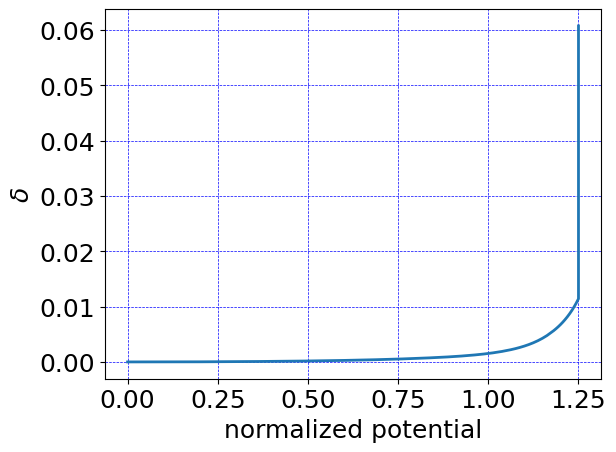

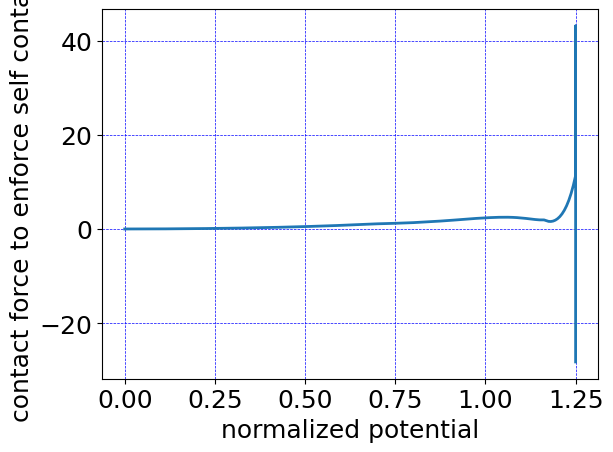

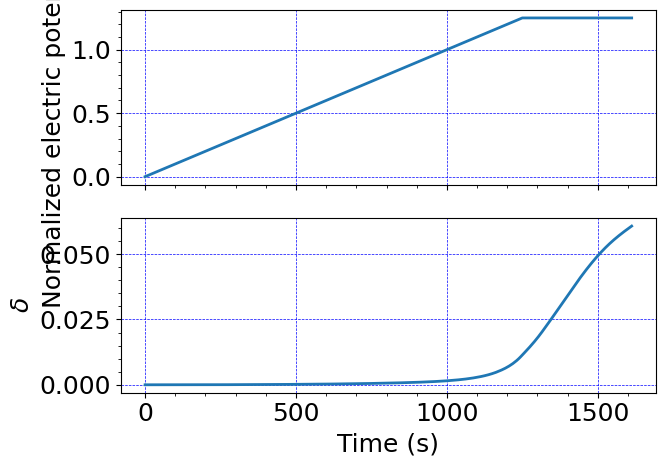

In [73]:
# set plot font to size 18
font = {'size'   : 18}
plt.rc('font', **font)

# Get array of default plot colors
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']


# Only plot as far as we have time history data
ind = np.argmax(timeHist0) + 1


time = timeHist0[0:ind]
normVolts = timeHist1[0:ind]/(height * np.sqrt(float(Geq_0)/float(vareps))) 
delta = np.abs(timeHist2[0:ind]-timeHist3[0:ind])/height
contactForce = timeHist4[0:ind]


fig = plt.figure()
plt.plot( normVolts, delta, color=colors[0], linewidth=2.0)
plt.grid(linestyle="--", linewidth=0.5, color='b')
plt.xlabel('normalized potential')
plt.ylabel('$\delta$')




fig = plt.figure()
plt.plot( normVolts, contactForce, color=colors[0], linewidth=2.0)
plt.grid(linestyle="--", linewidth=0.5, color='b')
plt.xlabel('normalized potential')
plt.ylabel('contact force to enforce self contact')






# Two-axis plotting
fig, (ax1, ax2) = plt.subplots(2,1, sharex='col')

ax1.plot(timeHist0[0:ind], normVolts[0:ind], c=colors[0], linewidth=2.0)
ax1.grid(linestyle="--", linewidth=0.5, color='b')
ax1.set_ylabel('Normalized electric potential (kV)')
# ax1.set_xlim([0,5])
from matplotlib.ticker import AutoMinorLocator,FormatStrFormatter
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())

ax2.plot(timeHist0[0:ind], np.abs(timeHist2[0:ind]-timeHist3[0:ind])/height, c=colors[0], linewidth=2.0)
ax2.grid(linestyle="--", linewidth=0.5, color='b')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('$\delta$')
from matplotlib.ticker import AutoMinorLocator,FormatStrFormatter
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())


fig = plt.gcf()
fig.set_size_inches(7,5)
plt.tight_layout()
plt.savefig("results/electro-viscoelastic-crease.png", dpi=600)


In [74]:
# np.savetxt('ElectroCreaseData1e-3LoadUnload.csv', np.vstack((timeHist0[0:ind],timeHist1[0:ind],\
#     timeHist2[0:ind], timeHist3[0:ind], timeHist4[0:ind])).T, delimiter=',')

In [75]:
# # Read in the previously saved load/unload data for plotting
# #
# LoadUnloadData = np.genfromtxt('ElectroCreaseData1e-3LoadUnload.csv', delimiter=',')
# LoadUnloadTime = LoadUnloadData[:,0]
# LoadUnloadNormVolts = LoadUnloadData[:,1]/(height * np.sqrt(float(Geq_0)/float(vareps))) 
# # LoadUnloadDelta = np.abs(LoadUnloadData[:,2]-LoadUnloadData[:,3])/height
# LoadUnloadDelta = LoadUnloadData[:,2]
# #
# LoadHoldData = np.genfromtxt('ElectroCreaseData1e-3Hold.csv', delimiter=',')
# LoadHoldTime = LoadHoldData[:,0]
# LoadHoldNormVolts = LoadHoldData[:,1]/(height * np.sqrt(float(Geq_0)/float(vareps))) 
# # LoadHoldDelta = np.abs(LoadHoldData[:,2]-LoadHoldData[:,3])/height
# LoadHoldDelta = LoadHoldData[:,2]

# fig = plt.figure()
# plt.plot(LoadHoldNormVolts, LoadHoldDelta, color=colors[0], linewidth=2.0, label='Load-Hold')
# plt.plot(LoadUnloadNormVolts, LoadUnloadDelta, color=colors[1], linewidth=2.0, linestyle='--', label='Load-Unload')
# plt.text(LoadHoldNormVolts[-1],LoadHoldDelta[-1], r'X', color='k',\
#            horizontalalignment='center',verticalalignment='center')
# plt.grid(linestyle="--", linewidth=0.5, color='b')
# plt.legend(loc="lower left")
# plt.xlabel('Normalized Potential')
# plt.ylabel('$\delta$')
# plt.xlim([0.0, 1.3])
# plt.ylim([-7.0, 0.0])

# fig = plt.gcf()
# fig.set_size_inches(7,5)
# plt.tight_layout()
# plt.savefig("results/electrocreasePotentialDelta.png", dpi=600)






# fig = plt.figure()
# plt.plot(LoadHoldTime, LoadHoldNormVolts, color=colors[0], linewidth=2.0, label='Load-Hold')
# plt.plot(LoadUnloadTime, LoadUnloadNormVolts, color=colors[1], linewidth=2.0, linestyle='--', label='Load-Unload')
# plt.text(LoadHoldTime[-1],LoadHoldNormVolts[-1], r'X', color='k',\
#            horizontalalignment='center',verticalalignment='center')
# plt.grid(linestyle="--", linewidth=0.5, color='b')
# plt.legend(loc="lower center")
# plt.xlabel('Time (s)')
# plt.ylabel('Normalized Potential')
# plt.xlim([0.0, 2500.0])
# plt.ylim([0.0, 1.3])

# fig = plt.gcf()
# fig.set_size_inches(7,5)
# plt.tight_layout()
# plt.savefig("results/electrocreaseTimePotential.png", dpi=600)
